## Perplexity testing of RNN, LSTM, and GRU


In [1]:
# run in colab
def runInColab_ver_1():
    !pip install  torchmetrics
    !pip install nbformat
    !pip install ipympl


    from google.colab import drive
    print('\n')
    drive.mount('/content/drive', force_remount=True)
    %cd '/content/drive/My Drive/code_dev_material/Vehicles_faults_detection/generating_text/Text-Generation-PyTorch'

    print('default folder: ')
    !pwd

    import os
    print('os cpu count',os.cpu_count())


    from google.colab import output

    output.enable_custom_widget_manager()



runInColab_ver_1()


%reload_ext autoreload
%autoreload 2
#%matplotlib widget

!nvidia-smi
print('\n')
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')



Mounted at /content/drive
/content/drive/My Drive/code_dev_material/Vehicles_faults_detection/generating_text/Text-Generation-PyTorch
default folder: 
/content/drive/My Drive/code_dev_material/Vehicles_faults_detection/generating_text/Text-Generation-PyTorch
os cpu count 2
Sat Jul  1 00:16:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360M

In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
training_data = [
    "The cat found the ball with mud",
    "Everybody read that twitter message",
    "Everybody knows what machine learning does",
]

test_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    ["Determiner", "Noun", "Verb", "Determiner", "Noun", "Determiner", "Noun"],
    ["Noun", "Verb", "Determiner", "Noun", "Noun"],
    ["Noun", "Verb", "Adverb", "Noun", "Noun", "Verb"],
]

# Assign each tag with a unique index
tag_to_index = {"Determiner": 0, "Noun": 1, "Verb": 2, "Adverb": 3}

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")


def yield_tokens():
    for text in training_data:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(), specials=[" "])
vocab.set_default_index(vocab[" "])

transform_pipeline = lambda x: vocab(tokenizer(x))

In [5]:
print("length of vocabulary", len(vocab))

length of vocabulary 17


In [6]:
for i in range(len(vocab)):
    print(vocab.lookup_tokens([i]))

vocab(tokenizer("Everybody knows what machine learning does"))

[' ']
['everybody']
['the']
['ball']
['cat']
['does']
['found']
['knows']
['learning']
['machine']
['message']
['mud']
['read']
['that']
['twitter']
['what']
['with']


[1, 7, 15, 9, 8, 5]

In [7]:
EMBEDDING_DIM = 8
HIDDEN_DIM = 12
VOCAB_SIZE = len(vocab)
NUM_CLASSES = len(tag_to_index)

In [8]:
from torchmetrics.functional.text.perplexity import perplexity


def train(model, optimizer, criterion, epochs):
    epoch_losses = []
    epoch_perplexities = []

    for _ in range(epochs):
        final_loss = 0
        final_perplexities = 0
        for sentence, tags in zip(training_data, test_data):
            model.zero_grad()

            sentence_in = vocab(tokenizer(sentence))
            sentence_in = torch.tensor(sentence_in, dtype=torch.long)

            targets = [tag_to_index[w] for w in tags]

            targets = torch.tensor(targets, dtype=torch.long)

            tag_scores = model(sentence_in)

            loss = criterion(tag_scores, targets)
            perplexity_score = perplexity(
                tag_scores.view(1, tag_scores.shape[0], tag_scores.shape[1]),
                targets.view(1, -1),
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            final_loss += loss.item()
            final_perplexities += perplexity_score.item()

        epoch_losses.append(final_loss / len(test_data))
        epoch_perplexities.append(final_perplexities / len(test_data))

    return epoch_losses, epoch_perplexities

### Recurrent Neural Networks (RNN)


In [9]:
class RNNTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RNNTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        rnn_out, _ = self.rnn(
            embeds.view(len(sentence), 1, -1)
        )

        tag_space = self.hidden2tag(rnn_out.view(len(sentence), -1))

        return F.log_softmax(tag_space, dim=1)

In [10]:
model = RNNTagger(EMBEDDING_DIM, HIDDEN_DIM, len(vocab), len(tag_to_index))
loss_function = nn.NLLLoss()

epochs=150
lr=0.1
optimizer = optim.SGD(model.parameters(), lr=lr)


total_losses, total_perplexities = train(model, optimizer, loss_function, epochs)
print("total_losses:", total_losses)
print("total_perplexities:", total_perplexities)

total_losses: [1.4556556542714436, 1.3317164580027263, 1.236066182454427, 1.1560465892155964, 1.085782488187154, 1.0221744775772095, 0.9633841514587402, 0.9082416693369547, 0.8559888402620951, 0.8061331311861674, 0.7583539485931396, 0.7124413450558981, 0.6682596902052561, 0.6257311503092448, 0.5848304231961569, 0.5455700556437174, 0.5079776346683502, 0.4720863501230876, 0.43794820706049603, 0.40565064549446106, 0.3753109723329544, 0.3470438967148463, 0.32091990609963733, 0.2969403862953186, 0.27503762145837146, 0.2550926407178243, 0.23695739110310873, 0.2204731603463491, 0.20548261950413385, 0.19183720151583353, 0.17940031488736471, 0.16804863015810648, 0.15767212957143784, 0.14817298452059427, 0.13946454475323358, 0.131470096608003, 0.12412164111932118, 0.11735850324233373, 0.11112657934427261, 0.1053773748377959, 0.10006721317768097, 0.0951567900677522, 0.09061050166686375, 0.08639619623621304, 0.08248478298385938, 0.07884982973337173, 0.0754673791428407, 0.07231581583619118, 0.06937

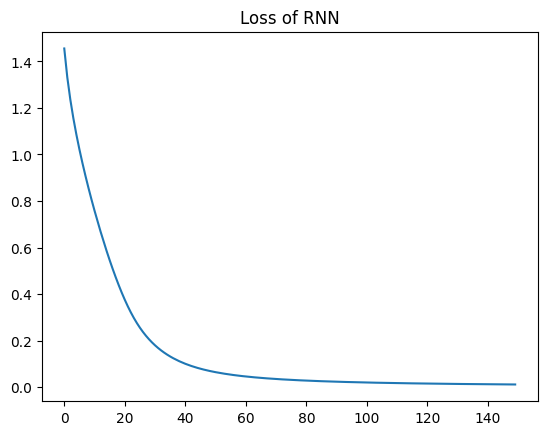

In [11]:
import math

plt.title("Loss of RNN")
plt.plot(np.arange(len(total_losses)), total_losses)
plt.show()

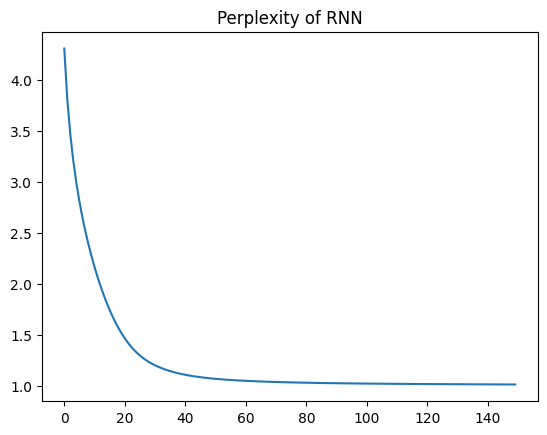

In [12]:
plt.title("Perplexity of RNN")
plt.plot(np.arange(len(total_perplexities)), total_perplexities)

### Long Short-Term Memory (LSTM)


In [13]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        return F.log_softmax(tag_space, dim=1)

In [14]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(vocab), len(tag_to_index))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
total_losses, total_perplexities = train(model, optimizer, loss_function, epochs)
print("total_losses:", total_losses)
print("total_perplexities:", total_perplexities)

total_losses: [1.365537206331889, 1.3313675721486409, 1.3029700915018718, 1.2793399492899578, 1.2596242825190227, 1.243104616800944, 1.2291823625564575, 1.2173629999160767, 1.2072409788767497, 1.1984861294428508, 1.190831224123637, 1.1840603351593018, 1.1779998540878296, 1.1725098292032878, 1.1674779256184895, 1.162813385327657, 1.1584428946177165, 1.1543066104253132, 1.1503560543060303, 1.1465509335199993, 1.1428580284118652, 1.1392491261164348, 1.1357005834579468, 1.1321920951207478, 1.1287057399749756, 1.1252260605494182, 1.1217393080393474, 1.1182327270507812, 1.1146949529647827, 1.1111155152320862, 1.1074845592180889, 1.1037927269935608, 1.1000316143035889, 1.0961925188700359, 1.0922677119572957, 1.0882492462793987, 1.0841299891471863, 1.0799027283986409, 1.0755602518717449, 1.071095883846283, 1.0665027300516765, 1.0617743730545044, 1.0569044748942058, 1.0518865585327148, 1.0467145244280498, 1.0413823127746582, 1.0358838041623433, 1.0302132964134216, 1.0243649085362752, 1.01833283

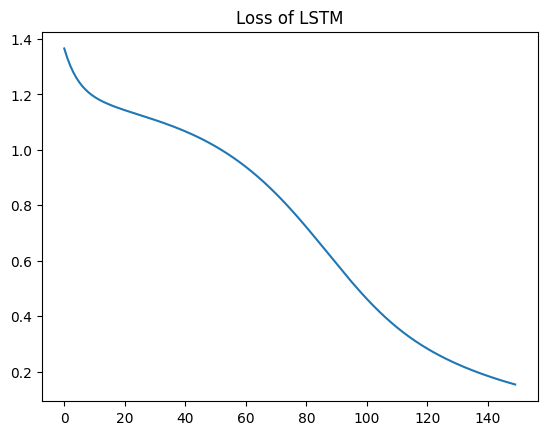

In [15]:
plt.title("Loss of LSTM")
plt.plot(np.arange(len(total_losses)), total_losses)

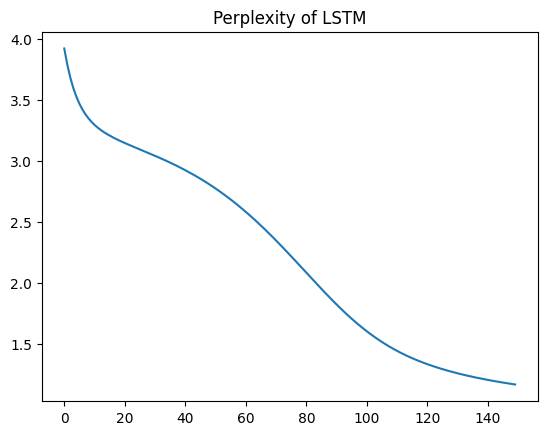

In [16]:
plt.title("Perplexity of LSTM")
plt.plot(np.arange(len(total_perplexities)), total_perplexities)
plt.show()

In [17]:
class GRUTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(GRUTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        gru_out, _ = self.gru(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(gru_out.view(len(sentence), -1))
        return F.log_softmax(tag_space, dim=1)

In [18]:
model = GRUTagger(EMBEDDING_DIM, HIDDEN_DIM, len(vocab), len(tag_to_index))

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
total_losses, total_perplexities = train(model, optimizer, loss_function, epochs)
print("total_losses:", total_losses)
print("total_perplexities:", total_perplexities)

total_losses: [1.4074088335037231, 1.3444027503331502, 1.2926530838012695, 1.250335971514384, 1.2157339255015056, 1.1872167587280273, 1.1633153359095256, 1.1427984635035198, 1.124702254931132, 1.1083127458890278, 1.0931211312611897, 1.078771710395813, 1.0650171438852947, 1.0516826907793682, 1.0386412541071575, 1.0257965922355652, 1.0130728085835774, 1.0004067023595173, 0.9877445499102274, 0.9750395814577738, 0.962250272432963, 0.9493401646614075, 0.9362777471542358, 0.9230358997980753, 0.9095926682154337, 0.8959309061368307, 0.8820380965868632, 0.8679066101710001, 0.8535319765408834, 0.8389132420221964, 0.8240514198939005, 0.8089486360549927, 0.7936074137687683, 0.778030534585317, 0.7622206409772238, 0.746181050936381, 0.7299158374468485, 0.7134308020273844, 0.6967340707778931, 0.6798367500305176, 0.6627532839775085, 0.6455020507176717, 0.6281055907408396, 0.6105906267960867, 0.5929881632328033, 0.5753333568572998, 0.5576648116111755, 0.5400248169898987, 0.522458036740621, 0.5050112207

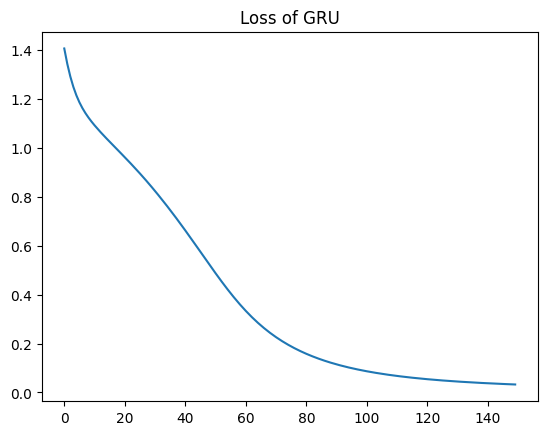

In [19]:
plt.title("Loss of GRU")
plt.plot(np.arange(len(total_losses)), total_losses)
plt.show()

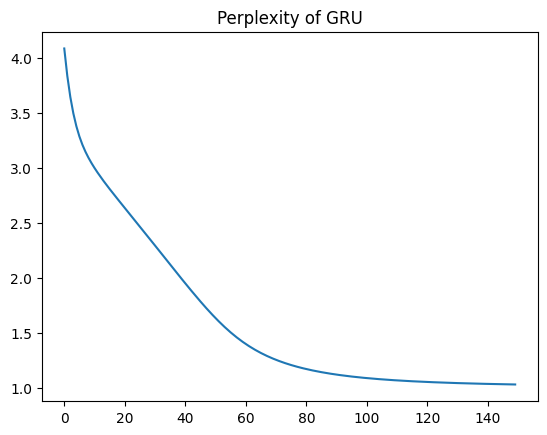

In [20]:
plt.title("Perplexity of GRU")
plt.plot(np.arange(len(total_perplexities)), total_perplexities)

We can see that in all three cases the loss and perplexity is being lowered with each training which means the algorithm is actually minimizing based on the loss function
